# Rapidly-Exploring Random Tree (RRT)

Generate an RRT:

```
def generate_RRT(x_init, num_vertices, dt):
    rrt = RRT(x_init)
    for k in range(num_vertices):
        x_rand = sample_state()
        x_near = nearest_neighbor(x_rand, rrt)
        u = select_input(x_rand, x_near)
        x_new = new_state(x_near, u, dt)
        # directed edge
        rrt.add_edge(x_near, x_new, u)
    return rrt
```
    
TODO: implementation of the following functions:

* `sample_state`
* `nearest_neighbor`
* `select_input`
* `new_state`


In [5]:
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.neighbors import KDTree
import networkx as nx

%matplotlib inline 

In [6]:
plt.rcParams['figure.figsize'] = 12, 12

In [20]:
class RRT:
    def __init__(self, x_init):
        # A tree is a special case of a graph with
        # directed edges and only one path to any vertex.
        self.tree = nx.DiGraph()
        self.tree.add_node(x_init)
                
    def add_vertex(self, x_new):
        self.tree.add_node(tuple(x_new))
    
    def add_edge(self, x_near, x_new, u):
        self.tree.add_edge(tuple(x_near), tuple(x_new), orientation=u)
        
    @property
    def vertices(self):
        return self.tree.nodes()
    
    @property
    def edges(self):
        return self.tree.edges()
                                                  

In [8]:
def create_grid():
    grid = np.zeros((100, 100))
    # build some obstacles
    grid[10:20, 10:20] = 1
    grid[63:80, 10:20] = 1
    grid[43:60, 30:40] = 1
    grid[71:86, 38:50] = 1
    grid[10:20, 55:67] = 1
    grid[80:90, 80:90] = 1
    grid[75:90, 80:90] = 1
    grid[30:40, 60:82] = 1
    return grid

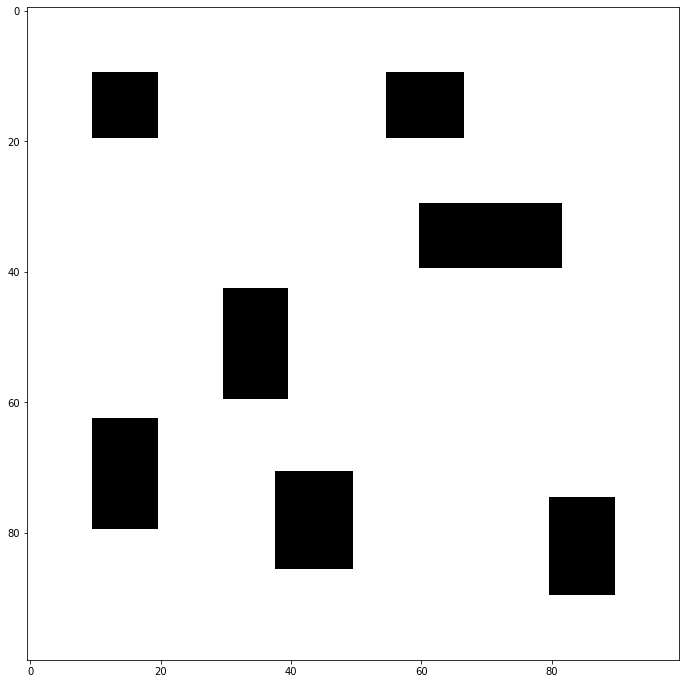

In [10]:
# environment encoded as a grid
grid = create_grid()

# Let's take a look at the example environment we'll be using.
plt.imshow(grid, cmap='Greys', origin='upper')

### Sampling States

The first part of generating an RRT is sampling states based on the environment. 

In [27]:
def sample_state(grid):
    x = np.random.uniform(0, grid.shape[0])
    y = np.random.uniform(0, grid.shape[1])
    return (x, y)

### Nearest Neighbors

A critical part of the RRT procedure is finding the closest vertex to the sampled random point. This the most computationally intensive part so be mindful of that. Depending on the number of vertices a naive implementation will run into trouble quickly.

In [12]:
def nearest_neighbor(x_rand, rrt):
    min_dist = 1000000
    min_node = None
    x = np.array(x_rand)
    for n in rrt.vertices:
        y = np.array(n)
        if min_dist > np.linalg.norm(y - x):
            min_dist = np.linalg.norm(y - x)
            min_node = n
                
    return min_node

### Selecting Inputs

Select input which moves `x_near` closer to `x_rand`. This should return the angle or orientation of the vehicle.

In [13]:
def select_input(x_rand, x_near):
    dy = x_rand[1] - x_near[1]
    dx = x_rand[0] - x_near[0]
    
    # tan(theta) = dy/dx
    # theta = atan(dy/dx)
    theta = np.arctan2(dy, dx)
    return theta   

### New State



The new vertex `x_new` is calculated by travelling from the current vertex `x_near` with a orientation `u` for time `dt`.

In [14]:
def new_state(x_near, u, dt):
    x = x_near[0] + np.cos(u)*dt
    y = x_near[1] + np.sin(u)*dt
    return [x, y]

### Putting It All Together

In [28]:
def generate_RRT(grid, x_init, num_vertices, dt):
    
    rrt = RRT(x_init)
    
    for _ in range(num_vertices):        
        
        x_rand = sample_state(grid)        
        # sample states until a free state is found
        while grid[int(x_rand[0]), int(x_rand[1])] == 1:
            x_rand = sample_state(grid)
            
        x_near = nearest_neighbor(x_rand, rrt)
        u = select_input(x_rand, x_near)
        x_new = new_state(x_near, u, dt)
            
        if grid[int(x_new[0]), int(x_new[1])] == 0:
            # the orientation `u` will be added as metadata to
            # the edge
            rrt.add_edge(x_near, x_new, u)
            
    return rrt

Feel free to change any of the values below.

In [29]:
num_vertices = 1000
dt = 0.2
x_init = (50, 50)

rrt = generate_RRT(grid, x_init, num_vertices, dt)

Now let's plot the generated RRT.

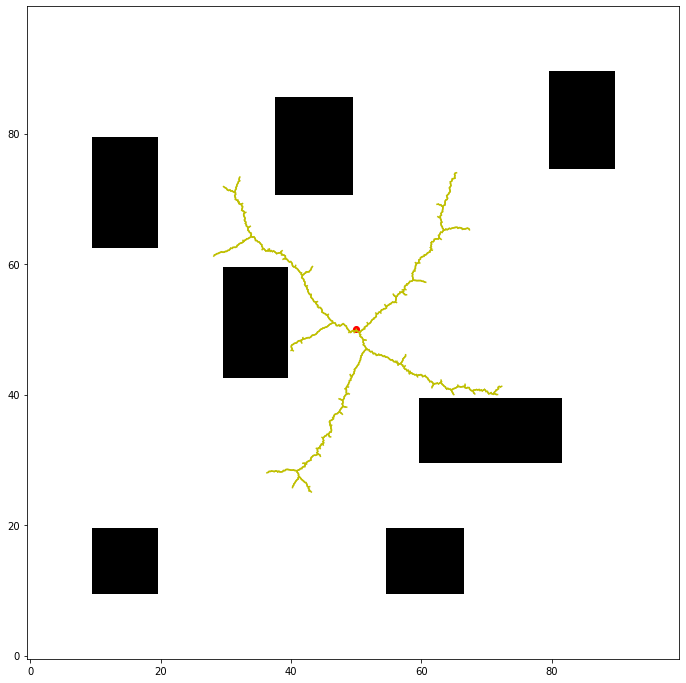

In [31]:
plt.imshow(grid, cmap='Greys', origin='lower')
plt.plot(x_init[1], x_init[0], 'ro')

for (v1, v2) in rrt.edges:
    plt.plot([v1[1], v2[1]], [v1[0], v2[0]], 'y-')

plt.show()